In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectPercentile, univariate_selection, RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score, RepeatedStratifiedKFold,\
StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix, precision_recall_curve, plot_precision_recall_curve, confusion_matrix
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
import category_encoders as ce
from scipy import stats

C:\Users\johan\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.univariate_selection module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
telco = pd.read_excel('Telco_customer_churn.xlsx')
telco.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [3]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [4]:
telco.describe()

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370,58.699418,4400.295755
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561,21.525131,1183.057152
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000,5.000000,2003.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000,40.000000,3469.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000,61.000000,4527.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000,75.000000,5380.500000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000,100.000000,6500.000000


In [5]:
def report(df):
    col = []
    d_type = []
    uniques = []
    n_uniques = []
    
    for i in df.columns:
        col.append(i)
        d_type.append(df[i].dtypes)
        uniques.append(df[i].unique()[:5])
        n_uniques.append(df[i].nunique())
    
    return pd.DataFrame({'Column': col, 'd_type': d_type, 'unique_sample': uniques, 'n_uniques': n_uniques})

In [6]:
report(telco)

,Column,d_type,unique_sample,n_uniques
0,CustomerID,object,"[3668-QPYBK, 9237-HQITU, 9305-CDSKC, 7892-POOK...",7043
1,Count,int64,[1],1
2,Country,object,[United States],1
3,State,object,[California],1
4,City,object,"[Los Angeles, Beverly Hills, Huntington Park, ...",1129
5,Zip Code,int64,"[90003, 90005, 90006, 90010, 90015]",1652
6,Lat Long,object,"[33.964131, -118.272783, 34.059281, -118.30742...",1652
7,Latitude,float64,"[33.964131, 34.059281, 34.048013, 34.062125, 3...",1652
8,Longitude,float64,"[-118.272783, -118.30742, -118.293953, -118.31...",1651
9,Gender,object,"[Male, Female]",2


Initially I will try to make a brief report on this data. From this report I will determine which columns to delete.

From the dataframe above, there are several columns that have one unique value, namely the column [Count, Country, State]. In addition, I will not use the CustomerID column because the customerID does not determine the probability that someone will churn or not.

Zip code, Lat Long, Latitude, Longitude will also be deleted. I won't use it to build Machine Learning.

I will delete Churn Score and Churn Reason in the end, because this will leak information for the model later. But for now, I will use it just for looking some insights.

In [7]:
new_col = telco.columns.str.replace(' ', '_')
telco.columns = new_col

In [8]:
telco.drop('CustomerID Count City Country State Zip_Code Lat_Long Latitude Longitude'.split(), axis=1, inplace=True)

In [9]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             7043 non-null   object 
 1   Senior_Citizen     7043 non-null   object 
 2   Partner            7043 non-null   object 
 3   Dependents         7043 non-null   object 
 4   Tenure_Months      7043 non-null   int64  
 5   Phone_Service      7043 non-null   object 
 6   Multiple_Lines     7043 non-null   object 
 7   Internet_Service   7043 non-null   object 
 8   Online_Security    7043 non-null   object 
 9   Online_Backup      7043 non-null   object 
 10  Device_Protection  7043 non-null   object 
 11  Tech_Support       7043 non-null   object 
 12  Streaming_TV       7043 non-null   object 
 13  Streaming_Movies   7043 non-null   object 
 14  Contract           7043 non-null   object 
 15  Paperless_Billing  7043 non-null   object 
 16  Payment_Method     7043 

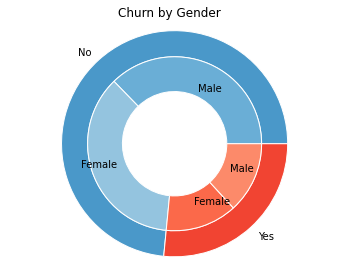

In [10]:
by_gender = telco.groupby('Churn_Label')['Gender'].value_counts().to_frame().rename(columns={'Gender': 'Freq'}).reset_index().sort_values('Churn_Label')

# Make data: I have 3 groups and 7 subgroups
group_names=telco['Churn_Label'].value_counts().index
group_size=telco['Churn_Label'].value_counts()
subgroup_names=by_gender['Gender']
subgroup_size=by_gender['Freq']
 
# Create colors
a, b =[plt.cm.Blues, plt.cm.Reds]
 
# First Ring (outside)
fig, ax = plt.subplots()
fig.suptitle('Churn by Gender')
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.6), b(0.6)])
plt.setp( mypie, width=0.3, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=[a(0.5), a(0.4), b(0.5), b(0.4)])
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)
 
# show it
plt.show()

In [11]:
telco.groupby('Churn_Label')['Gender'].value_counts(normalize=True).to_frame().rename(columns={'Gender': 'Ratio'}).reset_index().sort_values('Churn_Label')

,Churn_Label,Gender,Ratio
0,No,Male,0.507344
1,No,Female,0.492656
2,Yes,Female,0.502408
3,Yes,Male,0.497592


Note: From the visualization above, we can see that, the proportion for male and female to churn or retain is almost the same.

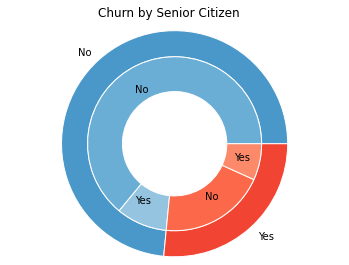

In [12]:
by_senior = telco.groupby('Churn_Label')['Senior_Citizen'].value_counts().to_frame().rename(columns={'Senior_Citizen': 'Freq'}).reset_index().sort_values('Churn_Label')

# Make data: I have 3 groups and 7 subgroups
group_names=telco['Churn_Label'].value_counts().index
group_size=telco['Churn_Label'].value_counts()
subgroup_names=by_senior['Senior_Citizen']
subgroup_size=by_senior['Freq']
 
# Create colors
a, b =[plt.cm.Blues, plt.cm.Reds]
 
# First Ring (outside)
fig, ax = plt.subplots()
fig.suptitle('Churn by Senior Citizen')
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.6), b(0.6)])
plt.setp( mypie, width=0.3, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=[a(0.5), a(0.4), b(0.5), b(0.4)])
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)

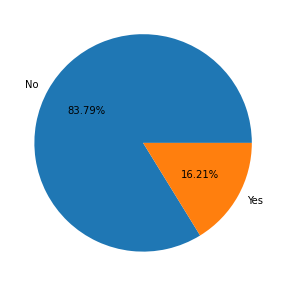

In [13]:
plt.figure(figsize=(10,5))
plt.pie(telco['Senior_Citizen'].value_counts(), labels=telco['Senior_Citizen'].unique(), autopct='%.2f%%')
plt.show()

In [14]:
telco['Senior_Citizen'].value_counts()

No     5901
Yes    1142
Name: Senior_Citizen, dtype: int64

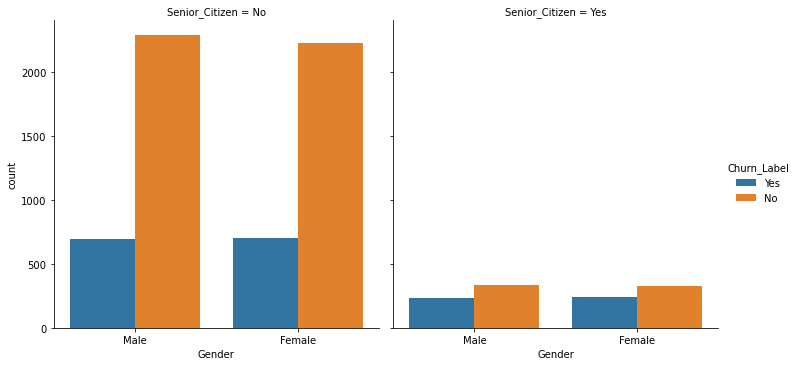

In [15]:
sns.catplot(x='Gender', hue='Churn_Label', col='Senior_Citizen', kind='count', data=telco)

In [16]:
by_gender_senior = telco.groupby(['Senior_Citizen', 'Gender'])['Churn_Label'].value_counts(normalize=True).to_frame().rename(columns={'Churn_Label': 'Ratio'}).reset_index().sort_values('Senior_Citizen')
by_gender_senior

,Senior_Citizen,Gender,Churn_Label,Ratio
0,No,Female,No,0.760616
1,No,Female,Yes,0.239384
2,No,Male,No,0.767192
3,No,Male,Yes,0.232808
4,Yes,Female,No,0.577465
5,Yes,Female,Yes,0.422535
6,Yes,Male,No,0.588850
7,Yes,Male,Yes,0.411150


Note:

From the visualization above, we can see that the churn and retain ratio for senior citizens, both male and female, is almost the same. Likewise, the churn and retain ratio for non-senior citizens. But if we look, the churn ratio has increased in senior citizens when compared to non-senior citizens.

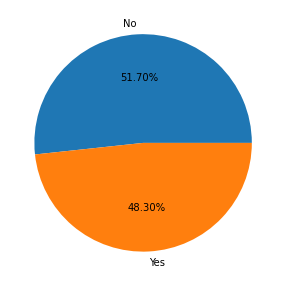

In [17]:
plt.figure(figsize=(10,5))
plt.pie(telco['Partner'].value_counts(), labels=telco['Partner'].unique(), autopct='%.2f%%')
plt.show()

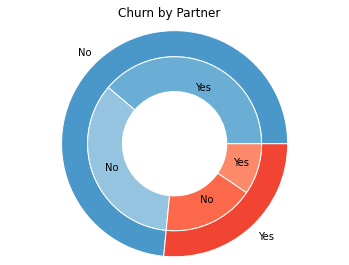

In [18]:
by_partner = telco.groupby('Churn_Label')['Partner'].value_counts().to_frame().rename(columns={'Partner': 'Freq'}).reset_index().sort_values('Churn_Label')

# Make data: I have 3 groups and 7 subgroups
group_names=telco['Churn_Label'].value_counts().index
group_size=telco['Churn_Label'].value_counts()
subgroup_names=by_partner['Partner']
subgroup_size=by_partner['Freq']
 
# Create colors
a, b =[plt.cm.Blues, plt.cm.Reds]
 
# First Ring (outside)
fig, ax = plt.subplots()
fig.suptitle('Churn by Partner')
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.6), b(0.6)])
plt.setp( mypie, width=0.3, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=[a(0.5), a(0.4), b(0.5), b(0.4)])
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)

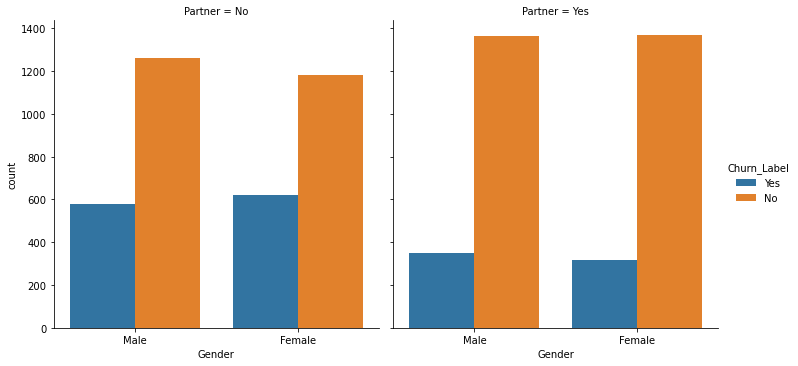

In [19]:
sns.catplot(x='Gender', hue='Churn_Label', col='Partner', kind='count', data=telco)
plt.show()


In [20]:
by_gender_partner = telco.groupby(['Partner', 'Gender'])['Churn_Label'].value_counts(normalize=True).to_frame().rename(columns={'Churn_Label': 'Ratio'}).reset_index().sort_values('Partner')
by_gender_partner

,Partner,Gender,Churn_Label,Ratio
0,No,Female,No,0.655556
1,No,Female,Yes,0.344444
2,No,Male,No,0.684954
3,No,Male,Yes,0.315046
4,Yes,Female,No,0.811019
5,Yes,Female,Yes,0.188981
6,Yes,Male,No,0.795799
7,Yes,Male,Yes,0.204201


From the visualization above, both female and male who do not have a partner are more likely to churn.

In [21]:
by_gp = telco.groupby(['Partner', 'Gender', 'Churn_Label'])
by_gp_mc = by_gp['Monthly_Charges'].mean().to_frame().reset_index().sort_values('Partner')
by_gp_mc_no = by_gp_mc[by_gp_mc['Partner'] == 'No']
by_gp_mc_yes = by_gp_mc[by_gp_mc['Partner'] == 'Yes']

In [22]:
by_gp_mc

,Partner,Gender,Churn_Label,Monthly_Charges
0,No,Female,No,58.989619
1,No,Female,Yes,73.170403
2,No,Male,No,55.664433
3,No,Male,Yes,69.612931
4,Yes,Female,No,63.970855
5,Yes,Female,Yes,78.002821
6,Yes,Male,No,65.695784
7,Yes,Male,Yes,81.448000


In [23]:
by_gp_mc_no

,Partner,Gender,Churn_Label,Monthly_Charges
0,No,Female,No,58.989619
1,No,Female,Yes,73.170403
2,No,Male,No,55.664433
3,No,Male,Yes,69.612931


In [24]:
by_gp_mc_yes

,Partner,Gender,Churn_Label,Monthly_Charges
4,Yes,Female,No,63.970855
5,Yes,Female,Yes,78.002821
6,Yes,Male,No,65.695784
7,Yes,Male,Yes,81.448000


C:\Users\johan\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\johan\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


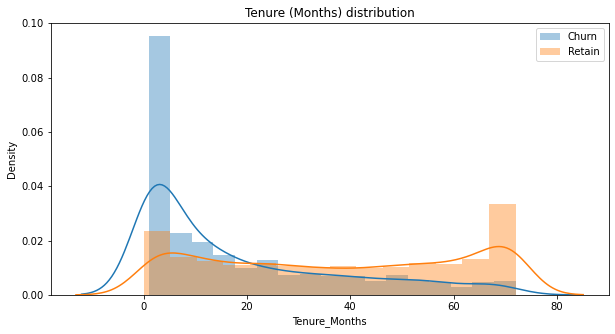

In [25]:
plt.figure(figsize=(10,5))
plt.title('Tenure (Months) distribution')
sns.distplot(telco[telco['Churn_Label'] == 'Yes']['Tenure_Months'], label='Churn')
sns.distplot(telco[telco['Churn_Label'] == 'No']['Tenure_Months'], label='Retain')
plt.legend(loc= 'upper right')
plt.show()

Note: From the visualization above, we can see that, the longer a person uses the provider, the probability of churn decreases.

C:\Users\johan\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\johan\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\johan\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

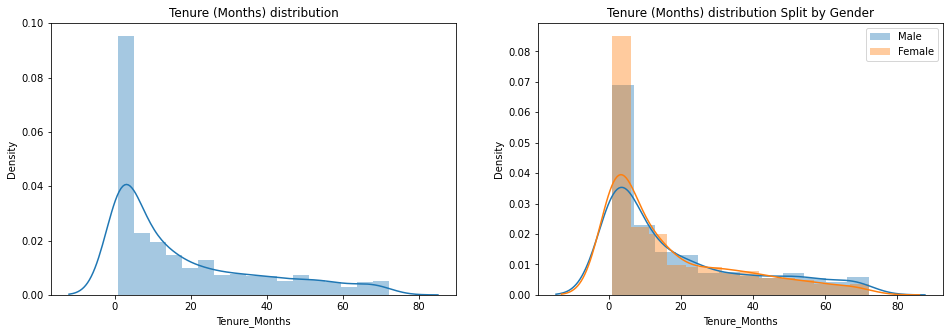

In [26]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.title('Tenure (Months) distribution')
sns.distplot(telco[telco['Churn_Label'] == 'Yes']['Tenure_Months'], label='Churn')
plt.subplot(1,2,2)
plt.title('Tenure (Months) distribution Split by Gender')
sns.distplot(telco[(telco['Churn_Label'] == 'Yes') & (telco['Gender'] == 'Male')]['Tenure_Months'], label='Male')
sns.distplot(telco[(telco['Churn_Label'] == 'Yes') & (telco['Gender'] == 'Female')]['Tenure_Months'], label='Female')
plt.legend()
plt.show()

Note: 

From the visualization above, most female users whose subscription period is less than 10 months, will be more likely to churn than male. However, the longer the subscription period, male are more likely to churn than female.

C:\Users\johan\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\johan\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


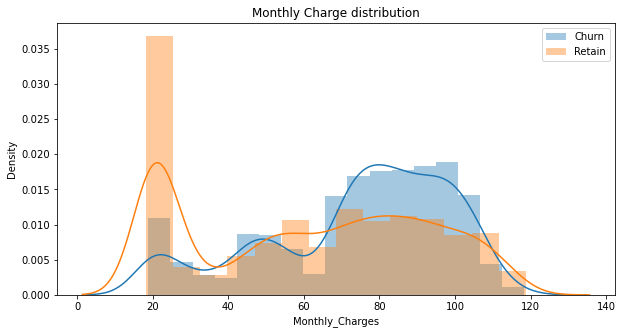

In [27]:
plt.figure(figsize=(10,5))
plt.title('Monthly Charge distribution')
sns.distplot(telco[telco['Churn_Label'] == 'Yes']['Monthly_Charges'], label='Churn')
sns.distplot(telco[telco['Churn_Label'] == 'No']['Monthly_Charges'], label='Retain')
plt.legend(loc= 'upper right')
plt.show()


Note:

From the visualization above, customers who make transactions per month on average more than $ 60, will be more likely to churn than the average transaction below that.

C:\Users\johan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\johan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


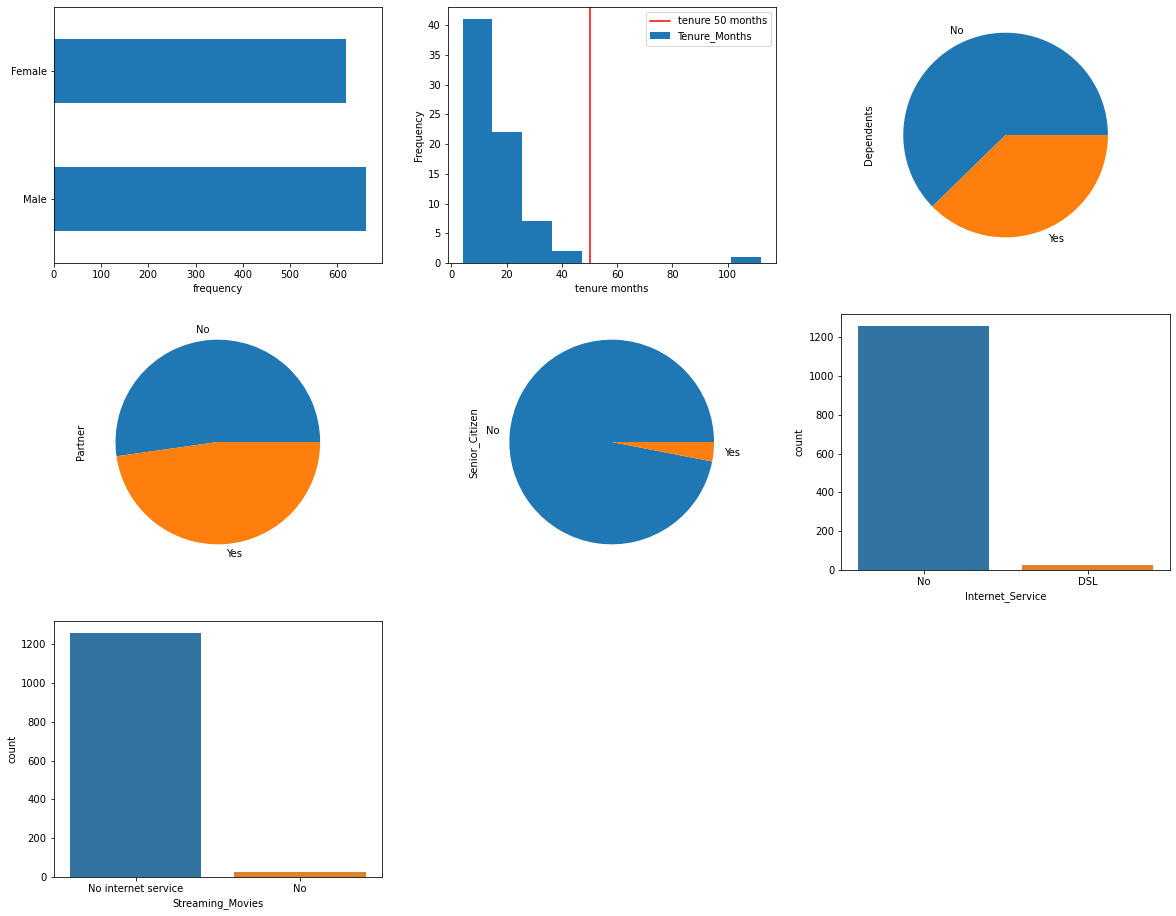

In [28]:
plt.figure(figsize=(20,16))
plt.subplot(331)
telco[(telco['Monthly_Charges'] <= 25) & (telco['Churn_Value']==0)]['Gender'].value_counts().plot(kind='barh')
plt.xlabel('frequency')
plt.subplot(332)
telco[(telco['Monthly_Charges'] <= 25) & (telco['Churn_Value']==0)]['Tenure_Months'].value_counts().plot(kind='hist')
plt.axvline(50, label='tenure 50 months', color='red')
plt.legend()
plt.xlabel('tenure months')
plt.subplot(333)
telco[(telco['Monthly_Charges'] <= 25) & (telco['Churn_Value']==0)]['Dependents'].value_counts().plot(kind='pie')
plt.subplot(334)
telco[(telco['Monthly_Charges'] <= 25) & (telco['Churn_Value']==0)]['Partner'].value_counts().plot(kind='pie')
plt.subplot(335)
telco[(telco['Monthly_Charges'] <= 25) & (telco['Churn_Value']==0)]['Senior_Citizen'].value_counts().plot(kind='pie')
plt.subplot(336)
internet_service_df = telco[(telco['Monthly_Charges'] <= 25) & (telco['Churn_Value']==0)]['Internet_Service']
sns.countplot(internet_service_df)
plt.subplot(337)
streaming_movie_df = telco[(telco['Monthly_Charges'] <= 25) & (telco['Churn_Value']==0)]['Streaming_Movies']
sns.countplot(streaming_movie_df)

There is a peak for customer retainers whose monthly charge is around 20 dollars. From the visualization above, we can see that the majority of customers whose monthly charges are still around 20 dollars are customers with tenure months of under 50 months. Most of them are Non-Senior Citizens. They don't have an internet access and haven't subscribed to many products from the provider.

C:\Users\johan\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\johan\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\johan\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

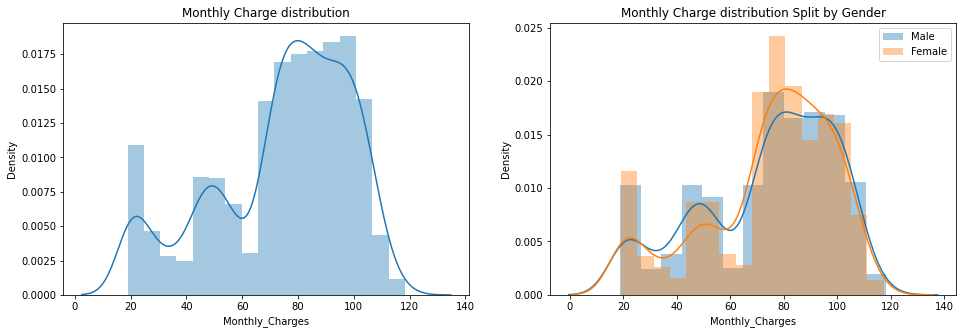

In [29]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.title('Monthly Charge distribution')
sns.distplot(telco[telco['Churn_Label'] == 'Yes']['Monthly_Charges'], label='Churn')
plt.subplot(1,2,2)
plt.title('Monthly Charge distribution Split by Gender')
sns.distplot(telco[(telco['Churn_Label'] == 'Yes') & (telco['Gender'] == 'Male')]['Monthly_Charges'], label='Male')
sns.distplot(telco[(telco['Churn_Label'] == 'Yes') & (telco['Gender'] == 'Female')]['Monthly_Charges'], label='Female')
plt.legend()
plt.show()

Note:

From the visualization above, the odds between men and women to churn is almost the same in every level of monthly charges.

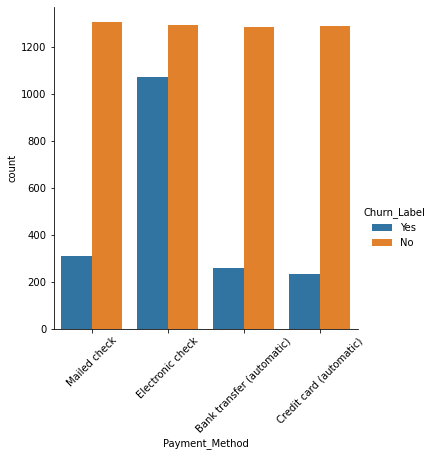

In [30]:
sns.catplot(x='Payment_Method', hue='Churn_Label', kind='count', data=telco)
plt.xticks(rotation=45)
plt.show()

In [31]:
pd.crosstab(telco['Payment_Method'], telco['Churn_Label'], normalize=0)

Churn_Label,No,Yes
Payment_Method,,
Bank transfer (automatic),0.832902,0.167098
Credit card (automatic),0.847569,0.152431
Electronic check,0.547146,0.452854
Mailed check,0.808933,0.191067


In [32]:
telco['Total_Charges'].replace(' ', np.nan, inplace=True)

In [33]:
telco['Total_Charges'].value_counts()

20.20      11
19.75       9
20.05       8
19.90       8
19.65       8
           ..
1673.80     1
434.10      1
5958.85     1
572.20      1
2610.65     1
Name: Total_Charges, Length: 6530, dtype: int64

In [34]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             7043 non-null   object 
 1   Senior_Citizen     7043 non-null   object 
 2   Partner            7043 non-null   object 
 3   Dependents         7043 non-null   object 
 4   Tenure_Months      7043 non-null   int64  
 5   Phone_Service      7043 non-null   object 
 6   Multiple_Lines     7043 non-null   object 
 7   Internet_Service   7043 non-null   object 
 8   Online_Security    7043 non-null   object 
 9   Online_Backup      7043 non-null   object 
 10  Device_Protection  7043 non-null   object 
 11  Tech_Support       7043 non-null   object 
 12  Streaming_TV       7043 non-null   object 
 13  Streaming_Movies   7043 non-null   object 
 14  Contract           7043 non-null   object 
 15  Paperless_Billing  7043 non-null   object 
 16  Payment_Method     7043 

In [35]:
pd.crosstab(telco['Payment_Method'], telco['Churn_Label'], values=telco['Total_Charges'], aggfunc=np.mean)

Churn_Label,No,Yes
Payment_Method,,
Bank transfer (automatic),3241.953388,2269.812984
Credit card (automatic),3201.189721,2350.257759
Electronic check,2609.989838,1463.656769
Mailed check,1178.173804,534.022565


# Modelling


For the modeling stage, this churn prediction will focus on as much as possible in predicting which customers will churn. As we know, if this model predicts 'retain' for a customer that will actually 'churn', then we will lose the customer. And according to some opinions, the cost of customer acquisition is 5 times greater than the cost of retaining the customer.

So that in modeling this time we will focus on recall. And we will try to use PR (Precision Recall) Curve to find the optimal threshold.

In [36]:
telco2 = telco.drop(['Churn_Label', 'Churn_Score', 'CLTV', 'Churn_Reason'], axis=1).copy()

In [37]:
telco2[['Monthly_Charges', 'Total_Charges']].corr()

,Monthly_Charges,Total_Charges
Monthly_Charges,1.000000,0.651065
Total_Charges,0.651065,1.000000


In [38]:
summary_df = report(telco2)
one_hot_cols = summary_df[summary_df['d_type']=='object']['Column']

In [39]:
summary_df

,Column,d_type,unique_sample,n_uniques
0,Gender,object,"[Male, Female]",2
1,Senior_Citizen,object,"[No, Yes]",2
2,Partner,object,"[No, Yes]",2
3,Dependents,object,"[No, Yes]",2
4,Tenure_Months,int64,"[2, 8, 28, 49, 10]",73
5,Phone_Service,object,"[Yes, No]",2
6,Multiple_Lines,object,"[No, Yes, No phone service]",3
7,Internet_Service,object,"[DSL, Fiber optic, No]",3
8,Online_Security,object,"[Yes, No, No internet service]",3
9,Online_Backup,object,"[Yes, No, No internet service]",3


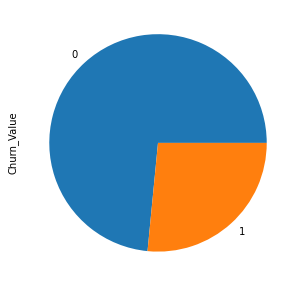

In [40]:
telco2['Churn_Value'].value_counts(normalize=True).plot(kind='pie', figsize=(5,5))

In [41]:
X = telco2.drop(columns='Churn_Value')
y = telco2['Churn_Value']

X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,test_size=.2, stratify=y)

In [42]:
logit = LogisticRegression(random_state=2021)
rfc = RandomForestClassifier(max_depth=10)
knn = KNeighborsClassifier(n_neighbors=5)
smote = SMOTE()

## Pipeline For LogisticRegression

In [43]:
telco2.isna().sum()/len(telco2)*100

Gender               0.000000
Senior_Citizen       0.000000
Partner              0.000000
Dependents           0.000000
Tenure_Months        0.000000
Phone_Service        0.000000
Multiple_Lines       0.000000
Internet_Service     0.000000
Online_Security      0.000000
Online_Backup        0.000000
Device_Protection    0.000000
Tech_Support         0.000000
Streaming_TV         0.000000
Streaming_Movies     0.000000
Contract             0.000000
Paperless_Billing    0.000000
Payment_Method       0.000000
Monthly_Charges      0.000000
Total_Charges        0.156183
Churn_Value          0.000000
dtype: float64

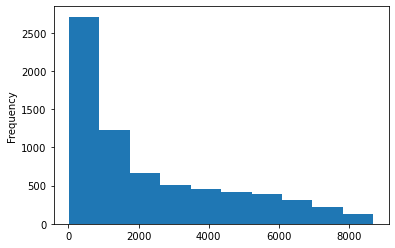

In [44]:
telco2['Total_Charges'].plot(kind='hist')

In [45]:
test, pval = stats.shapiro(telco2['Total_Charges'])

if pval < 0.05:
    print('normal')
else:
    print('not normal')

not normal


C:\Users\johan\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [46]:
# for monthly and total charges
logit_pipe_num = Pipeline([
    ('imputer', SimpleImputer(strategy='median', missing_values=np.nan)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=1))
])

# for all object columns
logit_pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(drop='first')),
])

# transforming all columns
logit_transformer = ColumnTransformer([
    ('pipe_num', logit_pipe_num, ['Monthly_Charges', 'Total_Charges']),
    ('pipe_cat', logit_pipe_cat, one_hot_cols)
])

# combine all pipeline
logit_pipe_combine = Pipeline([
    ('transformer', logit_transformer),
    ('rfe', RFE(logit)),
    ('resampling', smote),
    ('logit', logit)
])

## Pipeline For RandomForestClassifier¶

In [47]:
rfc_pipe_num = Pipeline([
    ('imputer', SimpleImputer(strategy='median', missing_values=np.nan))

])

# for all object columns
rfc_pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(drop='first')),
])

# transforming all columns
rfc_transformer = ColumnTransformer([
    ('pipe_num', rfc_pipe_num, ['Monthly_Charges', 'Total_Charges']),
    ('pipe_cat', rfc_pipe_cat, one_hot_cols)
])

# combine all pipeline
rfc_pipe_combine = Pipeline([
    ('transformer', rfc_transformer),
    ('rfe', RFE(rfc)),
    ('resampling', smote),
    ('rfc', rfc)
])

## Pipeline For KNeighborsClassifier

In [48]:
# for monthly and total charges
knn_pipe_num = Pipeline([
    ('imputer', SimpleImputer(strategy='median', missing_values=np.nan)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=1))
])

# for all object columns
knn_pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(drop='first')),
])

# transforming all columns
knn_transformer = ColumnTransformer([
    ('pipe_num', knn_pipe_num, ['Monthly_Charges', 'Total_Charges']),
    ('pipe_cat', knn_pipe_cat, one_hot_cols)
])

# combine all pipeline
knn_pipe_combine = Pipeline([
    ('transformer', knn_transformer),
    ('resampling', smote),
    ('knn', knn)
])

In [49]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [50]:
rskf = RepeatedStratifiedKFold(n_splits=5, random_state=2021)

logit_score = cross_val_score(logit_pipe_combine, X_train_val, y_train_val, scoring='recall', cv=rskf, n_jobs=-1, verbose=1)
rfc_score = cross_val_score(rfc_pipe_combine, X_train_val, y_train_val, scoring='recall', cv=rskf, n_jobs=-1, verbose=1)
knn_score = cross_val_score(knn_pipe_combine, X_train_val, y_train_val, scoring='recall', cv=rskf, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.7s finished


In [51]:
print('Logit Val Score:', logit_score)
print('RFC Val Score:', rfc_score)
print('KNN Val Score:', knn_score)

Logit Val Score: [0.76923077 0.78929766 0.78595318 0.81270903 0.81270903 0.78595318
 0.82274247 0.78929766 0.76923077 0.80602007 0.82274247 0.78595318
 0.78595318 0.81270903 0.76923077 0.81605351 0.78595318 0.77926421
 0.76254181 0.83277592 0.75585284 0.78929766 0.79264214 0.80267559
 0.81939799 0.77257525 0.76254181 0.81605351 0.81270903 0.79264214
 0.82274247 0.77257525 0.7458194  0.80936455 0.80936455 0.80267559
 0.81939799 0.75585284 0.75250836 0.81605351 0.79598662 0.79598662
 0.78595318 0.80602007 0.78595318 0.80267559 0.80602007 0.76254181
 0.82274247 0.76588629]
RFC Val Score: [0.65217391 0.67892977 0.59866221 0.63879599 0.66555184 0.63545151
 0.67558528 0.65551839 0.61538462 0.67558528 0.62541806 0.71237458
 0.63879599 0.65886288 0.62876254 0.64214047 0.66555184 0.6187291
 0.65551839 0.7090301  0.59531773 0.64214047 0.69565217 0.62207358
 0.66555184 0.64214047 0.64214047 0.67892977 0.63545151 0.62207358
 0.63879599 0.63545151 0.58528428 0.68227425 0.65217391 0.66889632
 0.6688

In [52]:
print('Logit Val Score:', logit_score.mean())
print('RFC Val Score:', rfc_score.mean())
print('KNN Val Score:', knn_score.mean())

Logit Val Score: 0.7929765886287626
RFC Val Score: 0.6478260869565218
KNN Val Score: 0.731438127090301


In [53]:
# logit_pipe_combine.get_params()

In [54]:
# rfc_pipe_combine.get_params()

In [55]:
# knn_pipe_combine.get_params()

## Tuning Logreg

In [56]:
logit_params = {
    'logit__C': np.linspace(0,1,10),
    'logit__solver': ['lbfgs', 'liblinear', 'newton-cg'],
    'transformer__pipe_num__imputer__strategy': ['median', 'mean']
}

rfc_params = {
    'rfc__max_depth': np.arange(10,16),
    'rfc__min_samples_split': np.arange(7,10),
    'transformer__pipe_num__imputer__strategy': ['median', 'mean']
}

knn_params = {
    'knn__n_neighbors': np.arange(3,8),
    'transformer__pipe_num__imputer__strategy': ['median', 'mean']
}

In [57]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
logit_grid = GridSearchCV(logit_pipe_combine, param_grid=logit_params, scoring='recall', cv=skf, verbose=1, n_jobs=-1)
logit_grid.fit(X_train_val, y_train_val)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   39.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('pipe_num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('pca',
                                                                                          PCA(n_components=1))]),
                                                                         ['Monthly_Charges',
                                              

In [58]:
logit_tuned = logit_grid.best_estimator_
logit_tuned_score = cross_val_score(logit_tuned, X_train_val, y_train_val, scoring='recall', cv=rskf, n_jobs=-1, verbose=1)
logit_tuned_score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.0s finished


array([0.7826087 , 0.7993311 , 0.78595318, 0.80267559, 0.81605351,
       0.7826087 , 0.82274247, 0.79598662, 0.77257525, 0.81270903,
       0.84280936, 0.78929766, 0.79598662, 0.81605351, 0.77257525,
       0.80602007, 0.79264214, 0.78595318, 0.75919732, 0.84280936,
       0.76923077, 0.79264214, 0.79264214, 0.7993311 , 0.82943144,
       0.77926421, 0.76254181, 0.82274247, 0.81605351, 0.79264214,
       0.82608696, 0.7826087 , 0.74247492, 0.81270903, 0.80936455,
       0.80602007, 0.82943144, 0.75250836, 0.76588629, 0.82274247,
       0.7993311 , 0.7993311 , 0.78929766, 0.80936455, 0.78929766,
       0.80936455, 0.81270903, 0.77257525, 0.82608696, 0.76254181])

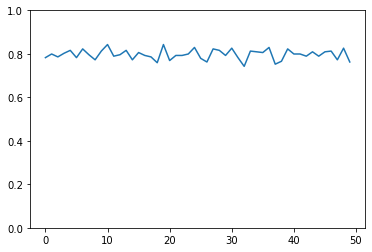

In [59]:
plt.plot(np.arange(len(logit_tuned_score)), logit_tuned_score)
plt.ylim(0,1)
plt.show()

## Tuned

In [60]:
logit_tuned_score.mean() # tuned dari cross val score

0.797056856187291

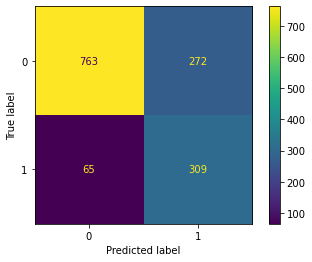

In [76]:
logit_tuned.fit(X_train_val, y_train_val)
plot_confusion_matrix(logit_tuned, X_test, y_test)

## Before Tuned

In [62]:
logit_score.mean() #benchmark hasil dari cross val score

0.7929765886287626

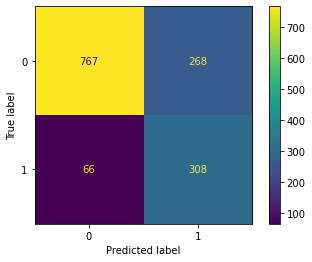

In [63]:
logit_pipe_combine.fit(X_train_val, y_train_val)
plot_confusion_matrix(logit_pipe_combine, X_test, y_test)

There is a very small increase in the recall score. We will try to continue to find the best threshold using the tuned Logistic Regression.

## Atur Treshold

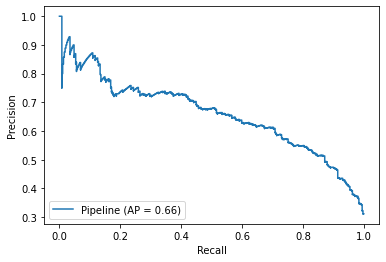

In [64]:
plot_precision_recall_curve(logit_tuned, X_test, y_test)

In [65]:
p, r, t = precision_recall_curve(y_test, logit_tuned.predict_proba(X_test)[:,1])
len(p[:-1]), len(r[:-1]), len(t)
pr_df = pd.DataFrame({'precision': p[:-1], 'recall': r[:-1], 'threshold': t})
pr_df

,precision,recall,threshold
0,0.311927,1.000000,0.064317
1,0.311352,0.997326,0.064320
2,0.311612,0.997326,0.064620
3,0.311873,0.997326,0.064652
4,0.312134,0.997326,0.064838
...,...,...,...
1183,0.800000,0.010695,0.924318
1184,0.750000,0.008021,0.925199
1185,1.000000,0.008021,0.928738
1186,1.000000,0.005348,0.929080


In [66]:
pr_df[(pr_df['recall'].between(0.8, 0.91)) & (pr_df['precision'].between(0.43, 0.5))].head(20)

,precision,recall,threshold
470,0.466392,0.909091,0.347457
471,0.467033,0.909091,0.348137
472,0.467675,0.909091,0.348525
473,0.466942,0.906417,0.348717
474,0.467586,0.906417,0.348888
475,0.468232,0.906417,0.349017
476,0.468880,0.906417,0.350618
477,0.469529,0.906417,0.350644
478,0.470180,0.906417,0.350845
479,0.470833,0.906417,0.351190


In [ ]:
clf = LogisticRegression(class_weight="balanced")
clf.fit(X_train, y_train)
THRESHOLD = 0.25
preds = np.where(clf.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

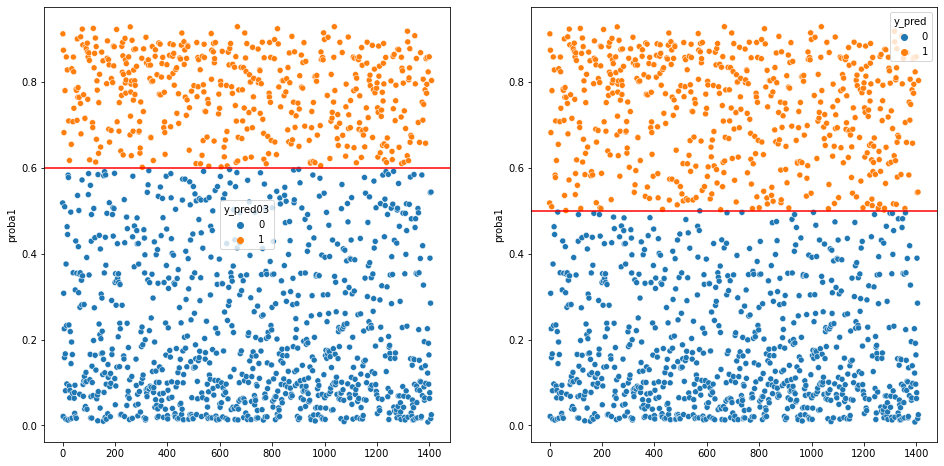

In [67]:
proba1 = logit_tuned.predict_proba(X_test)[:,1]
y_pred = logit_tuned.predict(X_test)
thresh =0.6
pred_03 = np.where(proba1 > thresh, 1, 0)
res_df = pd.DataFrame({'proba1': proba1, 'y_pred': y_pred, 'y_pred03': pred_03})
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.scatterplot(x=range(len(res_df)), y=res_df['proba1'], hue=res_df['y_pred03'])
plt.axhline(thresh, color='red')

plt.subplot(122)
sns.scatterplot(x=range(len(res_df)), y=res_df['proba1'], hue=res_df['y_pred'])
plt.axhline(0.5, color='red')

## Setelah di Tuned & di atur Treshold

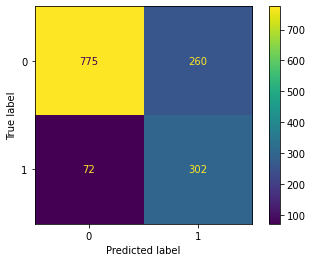

In [68]:
logit_pipe_combine.fit(X_train_val, y_train_val)
plot_confusion_matrix(logit_pipe_combine, X_test, y_test)

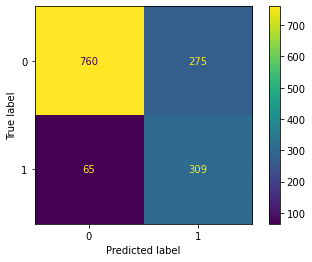

In [69]:
logit_tuned.fit(X_train_val, y_train_val)
plot_confusion_matrix(logit_tuned, X_test, y_test)

In [70]:
print("Customer who don't get a treatment and run away:", round(74/(764+74)*100,2),"%")
print("Customer who get a treatment but actually still with us:", round(271/(271+300)*100,2),"%")

Customer who don't get a treatment and run away: 8.83 %
Customer who get a treatment but actually still with us: 47.46 %


In [71]:
confusion_matrix(y_test, pred_03)

array([[836, 199],
       [101, 273]], dtype=int64)

In [72]:
print("Customer who don't get a treatment and run away:", round(33/(607+33)*100,2),"%")
print("Customer who get a treatment but actually still with us:", round(428/(428+341)*100,2),"%")

Customer who don't get a treatment and run away: 5.16 %
Customer who get a treatment but actually still with us: 55.66 %


## We did it!

We managed to lower our chances of letting off a churning customer.

### Summary:

From the confusion matrix above, we can conclude that, of the 100 people that our machine learning model predicts, only 5\% or only 5 people will pass or they won't get any treatment from us in order to keep using our services. Compared to the previous model, out of 100 people who are predicted to churn, 8.83\% or about 9 people will pass. There was a decrease of up to 44.4\%.

But this decline has consequences. Of the 100 people who are predicted to churn, 56\% or about 56 people will get treatment from us, but actually they have no problem with our services. And even they won't actually churn. This possibility increases when compared to the previous model, which is only 47\% or only 47 people who get treatment to stay with us. The increase is up to 19\%.

### In other words:

Based on the initial explanation, the cost of acquiring new customers is 5x the cost of retaining customers. So, suppose we have a budget to keep customers, of USD 50. So that automatically, we have a budget to get a new customer of USD 250.

Using the previous machine learning model, we would need USD 2250 to acquire new customers. Whereas using the new machine learning model, we only need USD 1250. Or we can save 44.4\%.

Meanwhile, the cost of retaining customers (USD 50) will increase. From USD 2350 to USD 2800 or there is a 19\% increase in costs.

### But if we look at the whole story:

1. The total cost of using the first machine learning model was USD 4600.
1. The total cost of using the second machine learning model is USD 4050.
1. In other words, using optimized machine learning can save costs by 12\%.